In [362]:
# %pip install 'imageio==2.4.0'
%pip install imageio
%pip install pyvirtualdisplay
%pip install tf-agents
%pip install pyglet
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [363]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
# import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy

# from tf_agents.replay_buffers import reverb_replay_buffer
# from tf_agents.replay_buffers import reverb_utils
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


from tf_agents.metrics import py_metrics


In [364]:
# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display().start()

In [365]:
tf.version.VERSION

'2.9.1'

In [366]:
# Hyperparameters
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [367]:
# Environment
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [368]:
#@test {"skip": true}
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.04969256,  0.04911944, -0.00646149, -0.03490542], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [369]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [370]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [371]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [372]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.0259609 , -0.02429077,  0.02262989,  0.02558723], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.02644671,  0.17049947,  0.02314163, -0.25987068], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [373]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [374]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [375]:
# Agent

# Layers
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
# Determines the Last Dense Layer from the Action space
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [376]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)


# Agent - DQN Agent itself

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [377]:
# Policies

eval_policy = agent.policy
collect_policy = agent.collect_policy

In [378]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [379]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [380]:
time_step = example_environment.reset()

In [381]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [382]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [383]:
avg_ret_rand = compute_avg_return(eval_env, random_policy, num_eval_episodes)
print('Average Retrun for Random Policy: ')
print(avg_ret_rand)

Average Retrun for Random Policy: 
22.6


In [384]:
replay_buffer_TFUniform = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec= agent.collect_data_spec,
    batch_size= train_env.batch_size,
    max_length=1000000
)

rb_observer = replay_buffer_TFUniform.add_batch

In [385]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [386]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [387]:
rb_observer

<bound method ReplayBuffer.add_batch of <tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer object at 0x13c963b50>>

In [388]:
# env = suite_gym.load('CartPole-v0')
# example_environment = tf_py_environment.TFPyEnvironment(env1)
env

In [389]:
# Data Collection

policy = py_tf_eager_policy.PyTFEagerPolicy(random_policy, use_tf_function=True)

#@test {"skip": true}
py_driver.PyDriver(
    train_env,
    policy,
    [rb_observer],
    max_steps=initial_collect_steps).run(train_env.reset())



    # Make sure the environment in PyDriver(...) has a Timestep of the same shape the Agent

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[-0.14185725, -0.8044202 ,  0.08170735,  1.0557128 ]],
       dtype=float32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}),
 ())

In [390]:
# It will show the saved iterations in the Replay Buffer

# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer_TFUniform.as_dataset()).next()


In [391]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer_TFUniform.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [392]:
iterator = iter(dataset)
print(iterator)

In [393]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

In [394]:
# agent.collect_policy

In [443]:
#@test {"skip": true}

try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_env.reset()


# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    train_env,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function=True, batch_time_steps=False),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  # time_step, _ = collect_driver.run(time_step)
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 54.371055603027344
step = 400: loss = 7.578723907470703
step = 600: loss = 5.812212944030762
step = 800: loss = 12.95777416229248
step = 1000: loss = 74.73551177978516
step = 1000: Average Return = 92.5999984741211
step = 1200: loss = 191.69456481933594
step = 1400: loss = 110.2414321899414
step = 1600: loss = 102.8580322265625
step = 1800: loss = 1609.0772705078125
step = 2000: loss = 2245.022705078125
step = 2000: Average Return = 196.39999389648438
step = 2200: loss = 3498.697509765625
step = 2400: loss = 352.2639465332031
step = 2600: loss = 1129.03271484375
step = 2800: loss = 339.00909423828125
step = 3000: loss = 1114.7520751953125
step = 3000: Average Return = 200.0
step = 3200: loss = 1436.749755859375
step = 3400: loss = 4754.6

In [449]:
returns

[11.4,
 92.6,
 196.4,
 200.0,
 200.0,
 200.0,
 148.8,
 200.0,
 190.7,
 195.5,
 193.1,
 178.6,
 182.2,
 200.0,
 188.1,
 51.2,
 24.3,
 185.1,
 178.4,
 173.4,
 171.5]

(1.969999599456786, 250.0)

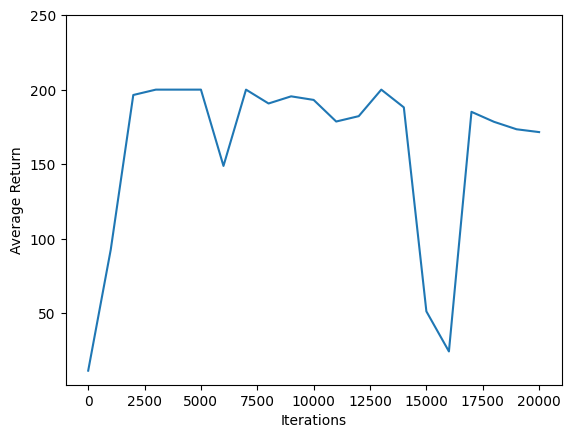

In [448]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)